In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import TSNE
from sklearn.manifold import MDS

In [2]:
df_average = pd.read_csv('../data/average_connectome_data.csv', header=0, index_col=0)

In [3]:
# filter the afferent / efferent based on hippocampal connections, create similarity matrix
hippocampal_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd'])

# FROM hippocampus (efferent)
df_avg_from = df_average[df_average.index.isin(hippocampal_regions)]

# TO hippocampus (afferent)
df_average_t = df_average.T
df_avg_to = df_average_t[df_average_t.index.isin(hippocampal_regions)]

# drop HPC columns
df_avg_from = df_avg_from.drop(hippocampal_regions, axis=1)
df_avg_to = df_avg_to.drop(hippocampal_regions, axis=1)

# filter to only include columns and rows with at least one connection
df_avg_from = df_avg_from.loc[:,df_avg_from.apply(np.count_nonzero, axis=0) >= 1]
df_avg_to = df_avg_to.loc[:,df_avg_to.apply(np.count_nonzero, axis=0) >= 1]

In [4]:
# compute correlation matrices
# probably want to drop na columns and rows of all NaNs
spearman_df_from = (df_avg_from.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
spearman_df_to = (df_avg_to.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

In [6]:
df_avg_from

,SI,MS,NDB,TRS,BSTam,BSTfu,BSTv,BSTmg,BSTdm,BSTal,...,AV,AMd,IAM,SMT,LH,VTA,PRC,COM,PAGrn,DTN
Abbr.,,,,,,,,,,,,,,,,,,,,,
DG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA3,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA1v,2.0,3.0,3.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
CA1d,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SUBv,2.0,0.0,0.0,0.0,4.0,1.0,2.0,2.0,2.0,2.0,...,0.0,0.0,1.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0
SUBd,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0


In [30]:
# define region groupings used in visualizations

# construct cortical
OLF_regions = np.array(['MOB','AOB','AOA','TTv','TTd','PIR','NLOT','TR'])
PARAH_regions = np.array(['IG','FC','ENTm','ENTl','PERI','ECT','CLA','6b'])
PFC_regions = np.array(['ILA','PL','ACAv','ACAd'])
ISU_regions = np.array(['AIv','AId','AIp'])
ORB_regions = np.array(['ORBv','ORBvl','ORBm','ORBl'])
PSM_regions = np.array(['MOp','MOs'])
SSR_regions = np.array(['SSp','SSs'])
AUD_regions = np.array(['AUDv','AUDp','AUDd','AUDpo'])
VIS_regions = np.array(['VISrl','VISal','VISlla','VISll','VISli','VISlm','VISpl','VISp','VISam','VISpm'])
EP_regions = np.array(['EPv','EPd'])
RSP_regions = np.array(['RSPv','RSPv.a','RSPv.b/c','RSPd','RSPagl'])
GVA_regions = np.array(['GU','VISC'])


cortical_regions = np.concatenate(
    (OLF_regions, PARAH_regions, PFC_regions, ISU_regions, ORB_regions, PSM_regions, SSR_regions, AUD_regions, VIS_regions, 
    EP_regions, RSP_regions, GVA_regions), axis=0
)

# hypothalamic regions
AHA_regions = np.array(['AHA', 'AHNa', 'AHNc', 'AHNp', 'AHNd'])
DHA_regions = np.array(['DMHa','DMHp','DMHv'])
mammillary_regions = np.array(['TM','MM','LM','SUMm','SUMl'])
LHA_regions = np.array([
    'LHAa','LHAjvv','LHAjvd','LHAjp','LHAjd','LHAsfa','LHAsfp','LHAs','LHAv','LHAd','LHAp'
])

hypothalamus_regions = np.concatenate(
    (AHA_regions, DHA_regions, mammillary_regions, LHA_regions), axis=0
)

# amygdala regions
CEA_regions = np.array(['CEAm','CEAl','CEAc'])
MEA_regions = np.array(['MEAav','MEAad','MEApv','MEApd'])
BST_regions = np.array([
    'BSTam','BSTfu','BSTv','BSTmg','BSTdm','BSTal','BSTov','BSTju','BSTrh','BSTpr','BSTif','BSTtr','BSTd','BSTse'
])

amygdala_non_aggregated_regions = np.array(['AAA','IA'])

amygdala_aggregated_regions = np.concatenate(
    (CEA_regions, MEA_regions, BST_regions), axis=0
)

# septal striatal regions
LS_aggregated_regions = np.array(['LSr.m.v','LSr.m.d','LSr.vl','LSr.dl','LSc.v','LSc.d','LSv'])

LS_non_aggregated_regions = np.array(['MS','NDB','ACB'])

hippocampus_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd','PAR', 'PRE', 'POST'])

septostri_regions = np.concatenate(
    (LS_aggregated_regions, LS_non_aggregated_regions), axis=0
)

/opt/anaconda3/envs/br2f/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/br2f/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


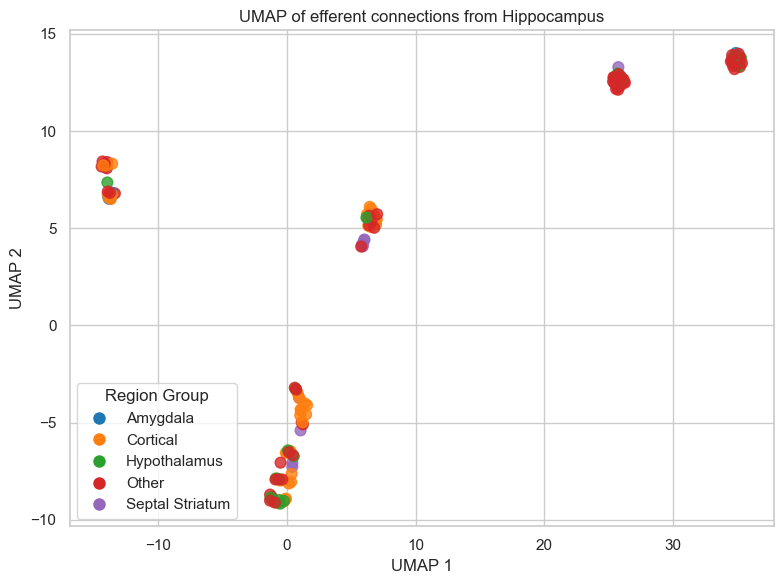

In [43]:
import umap
import matplotlib.pyplot as plt

dissimilarity_matrix = 1 - spearman_df_from

regions = list(dissimilarity_matrix.index)

# Assign each region to a group
region_groups = {}
for region in regions:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels = [region_groups[region] for region in regions]


# Compute UMAP embedding
reducer = umap.UMAP(metric='precomputed', n_neighbors=12, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(dissimilarity_matrix)

sns.set(style="whitegrid")

# Create a color palette
palette = sns.color_palette("tab10", len(set(region_labels)))
group_to_color = {group: palette[i] for i, group in enumerate(sorted(set(region_labels)))}
colors = [group_to_color[label] for label in region_labels]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=60, alpha=0.8)

# Annotate with legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      label=group, markersize=10,
                      markerfacecolor=color)
           for group, color in group_to_color.items()]
plt.legend(handles=handles, title="Region Group")
plt.title("UMAP of efferent connections from Hippocampus")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/br2f/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/br2f/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


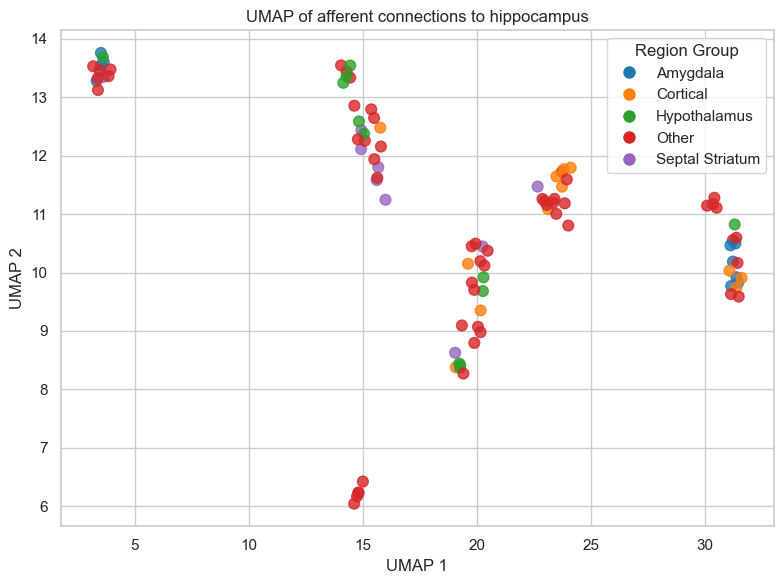

In [49]:
# Compute UMAP embedding
dissimilarity_matrix_a = 1 - spearman_df_to

regions_afferent = list(dissimilarity_matrix_a.index)

# Assign each region to a group
region_groups = {}
for region in regions_afferent:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels = [region_groups[region] for region in regions_afferent]

reducer = umap.UMAP(metric='precomputed', n_neighbors=12, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(dissimilarity_matrix_a)

sns.set(style="whitegrid")

# Create a color palette
palette = sns.color_palette("tab10", len(set(region_labels)))
group_to_color = {group: palette[i] for i, group in enumerate(sorted(set(region_labels)))}
colors = [group_to_color[label] for label in region_labels]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=60, alpha=0.8)

# Annotate with legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      label=group, markersize=10,
                      markerfacecolor=color)
           for group, color in group_to_color.items()]
plt.legend(handles=handles, title="Region Group")
plt.title("UMAP of afferent connections to hippocampus")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()

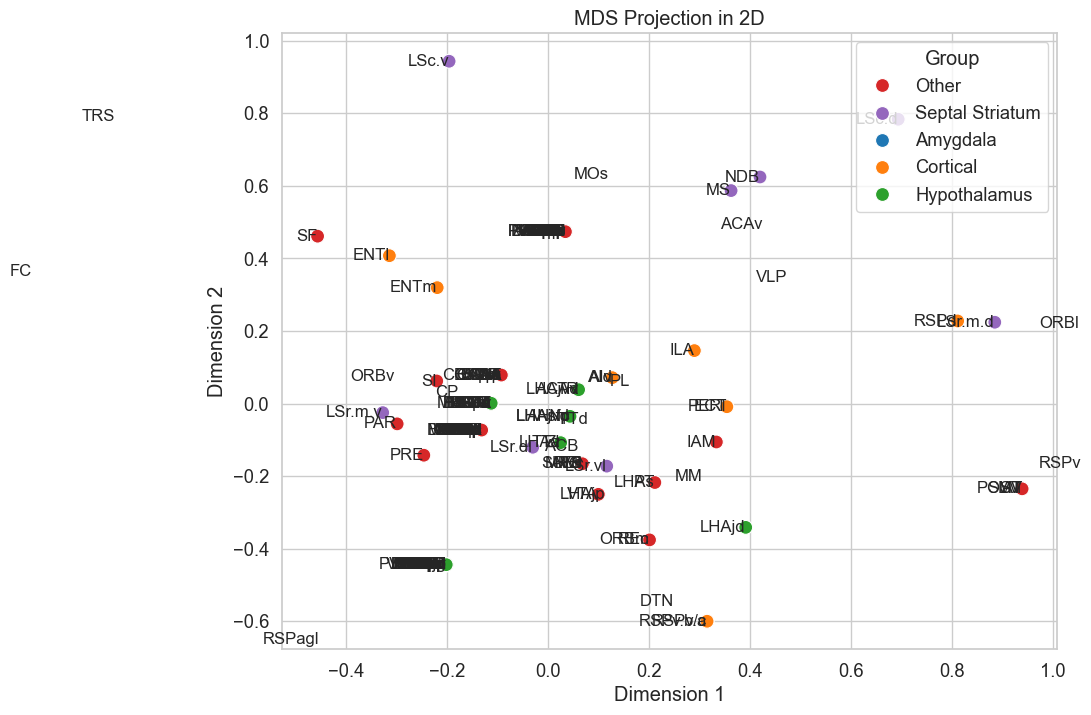

In [47]:
# do multidimensional scaling in 2D

dissimilarity_matrix_a = 1 - spearman_df_to

regions_afferent = list(dissimilarity_matrix_a.index)

# Assign each region to a group
region_groups = {}
for region in regions_afferent:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels = [region_groups[region] for region in regions_afferent]

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = mds.fit_transform(dissimilarity_matrix)

# Create a DataFrame for the results
mds_results = pd.DataFrame(embedding, columns=['Dim1', 'Dim2'], index=dissimilarity_matrix.index)
mds_results['Group'] = mds_results.index.map(region_groups)


# Plot the results
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

palette = sns.color_palette("tab10", len(set(region_labels)))
group_to_color = {group: palette[i] for i, group in enumerate(sorted(set(region_labels)))}

# Plot the results in 3D
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim1', y='Dim2', 
    data=mds_results, 
    hue='Group',  # Group coloring
    palette = group_to_color,
    # palette={'Cortical': 'red', 'Hypothalamus':'blue', 'Amygdala': 'purple', "Septal Striatum": 'pink','Other': 'green'}, 
    s=100, 
    marker='o'
)

# Annotate each point with its label
for label, (x, y, z) in mds_results.iterrows():
    plt.text(x, y, label, fontsize=12, ha='right', va='center')

# Add labels and title
plt.title("MDS Projection in 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")


plt.savefig("../output/MDS_2D_spearman_to.svg", format="svg")
# Show the plot
plt.show()